### Imports

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import plotly.express as px

In [ ]:
data=pd.read_csv("data\products.csv",sep='	')
data.head()

In [ ]:
data.shape

In [ ]:
data.columns

### Complétude des données

In [ ]:
data.info(verbose=True,show_counts=True)

In [ ]:
msno.bar(data)

In [ ]:
#Vérification des lignes dupliquées par code
data[(data.duplicated(subset='code',keep=False))&(~data['code'].isna())].sort_values(by='code')

In [ ]:
#pnns_groups_1 contient les catégories les plus proches de la séparation général/fromages/boissons du calcul du nutriscore
data['pnns_groups_1'].unique()

In [ ]:
data['countries_fr']

In [2]:
def filter_df(df):
    print('Séléction des données pour la France et filtrage des colonnes')
    print('Nombre de lignes et colonnes initial :',df.shape)
    filter_by_country=[('France' in str(countries)) for countries in df['countries_fr']]
    wanted_cat_columns=['code','countries_fr','last_modified_datetime','product_name','pnns_groups_1']
    filter_num=['_100g' in str(col) for col in df.columns]
    data=pd.concat([df.loc[filter_by_country,wanted_cat_columns],df.loc[filter_by_country,filter_num]],axis=1)
    print('Nombre de lignes et colonnes final',data.shape)
    return data

In [ ]:
filtered_df=filter_df(data)


In [3]:
def drop_empty (df) :
    print('Suppression des lignes sans nom de produit, avec moins de 50% de données numériques ou dupliquées et supprésion des colonnes vides (>25% nans)')
    print('Nombre de lignes et colonnes initial :',df.shape)
    df.dropna(subset='product_name',inplace=True)
    df.drop_duplicates(subset='code',keep='last',inplace=True)
    df.dropna(axis=1,thresh=df.shape[0]/4,inplace=True)
    df.dropna(subset=df.select_dtypes('number').columns,thresh=(df.select_dtypes('number').columns.shape[0])/2,inplace=True)
    print('Nombre de lignes et colonnes final',df.shape)
    nutri_cols=['pnns_groups_1','energy_100g','fat_100g','saturated-fat_100g','sugars_100g','proteins_100g','fiber_100g','sodium_100g','fruits-vegetables-nuts_100g']
    for col in nutri_cols:
        if col not in df.columns:
            print('Vérification des sous indicateurs de nutri-score : Trop de valeurs manquantes pour la colonne ',col,' : colonne supprimée.')
    msno.bar(df)
    plt.show()
    return df


In [ ]:
filtered_df=drop_empty(filtered_df)

In [ ]:
msno.matrix(filtered_df)
plt.show()

Les variables nécessaires au calcul du nutriscore sont : 
- type de produit : général,fromage,matières grasses ajoutées ou boisson (déductible de pnns_groups_1) 
- valeur énérgétique (energy_100g)
- matières grasses (fat_100g)
- Acides gras saturés (saturated-fat_100g)
- Sucres (sugars_100g) : Rq - Les sucres sont un type de carbohydrate
- Protéines (proteins_100g)
- Fibres (fiber_100g)
- Sel ou Sodium (salt_100g ou sodium_100g) : Rq - une formule de conversion sel vers sodium est proposée dans le calcul du nutriscore à [sodium]=[sel]*1000/2.5

(On retrouve l'ensemble des données ci-dessus dans le dataset filtré.)

- Pourcentage de fruits, légumes, légumineuses, fruits à coque, huiles de colza, de noix et d'olive (%)
Cet indicateur n'a pratiquement pas de données renseignées, il a donc été écarté.




In [ ]:
filtered_df.duplicated().any()

### Valeurs abhérentes

#### Colonnes numériques

##### Filtre par intervalles de valeurs acceptables

In [ ]:
filtered_df.describe()

La valeur d'énergie peut aller jusqu'à 900kcal soit 3780 KJ , la valeur de sodium en mg/100g, l'échelle de nutritrion score va de -15 à 40 et les autres valeurs sont en g/100g, ce qui nous donne les limites suivantes :

In [4]:
def drop_outofbounds(df):
    print('Verification des dépassements des limites de concentration pour 100g')
    #Vérification sodium
    filtre=(df['sodium_100g']>100000)|(df['sodium_100g']<0)
    if (filtre).any():
        print('Sodium : Valeurs hors limites : ',filtre.sum(),' lignes supprimées')
        display(df[filtre])
        df.drop(df[filtre].index,inplace=True)

    #Vérification nutriscores
    filtre_bas_nutriscore=df['nutrition-score-fr_100g']<-15
    filtre_haut_nutriscore=df['nutrition-score-fr_100g']>40
    filtre=filtre_bas_nutriscore|filtre_haut_nutriscore
    if (filtre).any():
        print('Nutriscore fr : Valeurs hors limites :',(filtre).sum(),'lignes supprimées')
        display(df[filtre])
        df.drop(df[filtre].index,inplace=True)
    filtre_bas_nutriscore=df['nutrition-score-uk_100g']<-15
    filtre_haut_nutriscore=df['nutrition-score-uk_100g']>40
    filtre=filtre_bas_nutriscore|filtre_haut_nutriscore
    if (filtre).any():
        print('Nutriscore uk : Valeurs hors limites :',(filtre).sum(),'lignes supprimées')
        display(df[filtre])
        df.drop(df[filtre].index,inplace=True)

    #Vérification calories
    filtre=(df['energy_100g']>3780)|(df['energy_100g']<0)
    if (filtre).any():
        print('Calories : Valeurs hors limites : ',(filtre).sum(),' lignes supprimées')
        display(df[filtre])
        df.drop(df[filtre].index,inplace=True)

    #Vérification des autres colonnes
    col_list=[col for col in df.columns if ('_100g' in str(col))&(col not in ['sodium_100g','nutrition-score-fr_100g','nutrition-score-uk_100g','energy_100g'])]

    for col in col_list:
        filtre=(df[col]>100)|(df[col]<0)
        if (filtre).any():
            print(col,': Valeurs hors limites : ',(filtre).sum(),' lignes supprimées')
            display(df [filtre])
            df.drop(df[filtre].index,inplace=True)
    return (df)

In [ ]:
#Tests pour la fonction drop_outofbounds
df_temp=filtered_df.copy()
df_temp.loc[0,'energy_100g']=-30
df_temp.loc[1,'energy_100g']=500000
df_temp.loc[3,'sodium_100g']=-30
df_temp.loc[4,'sodium_100g']=500000
df_temp.loc[5,'nutrition-score-uk_100g']=-30
df_temp.loc[6,'nutrition-score-fr_100g']=50


In [ ]:
drop_outofbounds(df_temp)

In [ ]:
filtered_df=drop_outofbounds(filtered_df)

In [ ]:
filtered_df.describe()

##### Filtre par vérification de la cohérence entre variables

Sodium vs sel

In [ ]:
incoherences_sodium=filtered_df[((filtered_df['salt_100g']*1000/2.5).round(0)-(filtered_df['sodium_100g']))>1][['salt_100g','sodium_100g']]
incoherences_sodium['sodium_estimé']=incoherences_sodium['salt_100g']*1000/2.5
incoherences_sodium

In [ ]:
#Il a l'air de s'agir majoritairement d'erreur d'unité pour le sodium, saisi en g ald mg

In [ ]:
# Ecarts entre sodium_estimé (en mg) et sodium_100g (hypothèse : saisi en g pour ceux où il y a des incohérences)
incoherences_sodium[(incoherences_sodium['sodium_estimé']/1000-incoherences_sodium['sodium_100g'])>1]

In [17]:
def correct_sodium_unit(df):
    filtre_sur_ecarts_sodium =((df['salt_100g']*1000/2.5).round(0)-(df['sodium_100g']))>1000
    filtre_sur_erreurs_unite = ((df['salt_100g']*1000/2.5)/1000-df['sodium_100g'])<1

    df.loc[filtre_sur_ecarts_sodium&filtre_sur_erreurs_unite,'sodium_100g']=df.loc[filtre_sur_ecarts_sodium&filtre_sur_erreurs_unite,'sodium_100g']*1000
    print('Correction des unités de sodium et suppression des lignes en anomalie')
    print('Nombre de lignes initial=',df.shape[0])
    df.drop(index=df[filtre_sur_ecarts_sodium].index,inplace=True) #Drop les lignes sur lequel il y a encore des erreurs
    print('Nombre de lignes final=',df.shape[0])
    return (df)
    

In [ ]:
filtered_df=correct_sodium_unit(filtered_df)

In [ ]:
sns.scatterplot(x=filtered_df['salt_100g'],
              y=filtered_df['sodium_100g'],
              color='slateblue',
              )
plt.suptitle('Teneur en sodium en fonction de la teneur en sel')    
plt.xlabel('Sel (en g par 100g de produit)')      
plt.ylabel('Sodium (en mg par 100g de produit)')      
plt.show()

Carbohydrates vs sucre

In [ ]:
# Sucres sont compris dans les carbohydrates :
filtered_df[(filtered_df['carbohydrates_100g']-filtered_df['sugars_100g'])<-0.9] #Marge de 0.9 prise pour les arrondis d'unité (ex carb=11.67,sug=11.7)

In [6]:
def drop_sugar_anomalies (df):
    print('Suppression des anomalies en sucre')
    print('Nombre de lignes initial=',df.shape[0])
    ano_index=(df[(df['carbohydrates_100g']-df['sugars_100g'])<-0.9]).index
    df.drop(index=ano_index,inplace=True)
    print('Nombre de lignes final=',df.shape[0])
    return (df)

In [ ]:
filtered_df=drop_sugar_anomalies (filtered_df)

In [ ]:
colors = ["white", "#FFD700"]  # White for empty zones, gold for density
cmap = sns.color_palette('Accent')

In [ ]:
sns.jointplot(x=filtered_df['sugars_100g'],
              y=filtered_df['carbohydrates_100g'],
              kind="hex",
              height=5,
              color='slateblue',
              cmap=sns.cubehelix_palette(start=2, dark=-20, light=1, reverse=False, as_cmap=True))
plt.suptitle('Teneur en carbohydrates en fonction de la teneur en sucres')    
plt.xlabel('Sucres (en g par 100g de produit)')      
plt.ylabel('Carbohydrates (en g par 100g de produit)')      
plt.show()

Saturated fat vs fat

In [ ]:
# Saturated fat est compris dans fat
filtered_df[(filtered_df['fat_100g']-filtered_df['saturated-fat_100g'])<-0.9]

In [21]:
def drop_fat_anomalies (df):
    print('Suppression des anomalies en gras')
    print('Nombre de lignes initial=',df.shape[0])
    ano_index=(df[(df['fat_100g']-df['saturated-fat_100g'])<-0.9]).index
    df.drop(index=ano_index,inplace=True)
    print('Nombre de lignes final=',df.shape[0])
    return (df)

In [ ]:
filtered_df=drop_fat_anomalies(filtered_df)

In [ ]:
sns.jointplot(x=filtered_df['saturated-fat_100g'],
              y=filtered_df['fat_100g'],
              kind="hex",
              height=5,
              color='slateblue',
              cmap=sns.cubehelix_palette(start=2, dark=-20, light=1, reverse=False, as_cmap=True))
plt.suptitle('Teneur en gras en fonction de la teneur en acides gras saturés')    
plt.xlabel('Acides gras saturés (en g par 100g de produit)')      
plt.ylabel('Gras (en g par 100g de produit)')      
plt.show()

##### Vérification statistique

In [ ]:
filtered_df.describe()

In [ ]:
filter_num=['_100g' in str(col) for col in filtered_df.columns]
filtered_df.loc[:,filter_num].columns

In [ ]:
fig,axes=plt.subplots(-(-len(filtered_df.loc[:,filter_num].columns)//3),3,figsize=(15, 15))
fig.tight_layout(pad=4.0)
for col,ax in zip(filtered_df.loc[:,filter_num].columns,axes.ravel()):
    sns.boxplot(y=filtered_df[col],ax=ax)
plt.suptitle('Distributions des variables')
plt.show()

In [ ]:
fig,axes=plt.subplots(-(-len(filtered_df.loc[:,filter_num].columns)//3),3,figsize=(15, 15))
fig.tight_layout(pad=4.0)
for col,ax in zip(filtered_df.loc[:,filter_num].columns,axes.ravel()):
    sns.histplot(filtered_df[col],ax=ax)
    ax.set_yscale("log")
plt.suptitle('Distributions des variables')
plt.show()

In [ ]:
num_stats=filtered_df.describe().T
num_stats['IQR']=num_stats['75%']-num_stats['25%']
num_stats['high_bound']=num_stats['75%']+1.5*num_stats['IQR']
num_stats['low_bound']=num_stats['25%']-1.5*num_stats['IQR']
num_stats

Rq : Les bornes inférieures sont négatives, vu qu'il y a déjà eu un filtre sur les valeurs <0, cette contrainte n'est pas utile.

In [ ]:
high_energy=filtered_df[filtered_df['energy_100g']>num_stats.loc['energy_100g','high_bound']]
high_energy

In [ ]:
high_energy['pnns_groups_1'].unique()

In [ ]:
high_energy['product_name'].unique()

Les produits au dessus du seuil ont bien des valeurs caloriques élévées (ex:3700 KJ en moyenne pour une huile d'olive). Il ne s'agit pas de valeurs abhérentes.

In [ ]:
len(filtered_df['pnns_groups_1'].unique())

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(data=filtered_df,y='energy_100g',x='pnns_groups_1')
plt.xlabel('pnns groups',fontsize=10)
plt.xticks(fontsize=7, rotation=90)
plt.hlines(xmin=0,xmax=len(filtered_df['pnns_groups_1'].unique())-1,y=num_stats.loc['energy_100g','high_bound'],color='red')
plt.title('Calories (en KJ) pour chaque groupe de produits et seuil haut de la méthode interquantile')
plt.show()

In [ ]:
high_fat=filtered_df[filtered_df['fat_100g']>num_stats.loc['fat_100g','high_bound']]
high_fat

In [ ]:
high_fat['pnns_groups_1'].unique()

In [ ]:
list(high_fat['product_name'].unique())

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(data=filtered_df,y='fat_100g',x='pnns_groups_1')
plt.xlabel('pnns groups',fontsize=10)
plt.xticks(fontsize=7, rotation=90)
plt.hlines(xmin=0,xmax=len(filtered_df['pnns_groups_1'].unique())-1,y=num_stats.loc['fat_100g','high_bound'],color='red')
plt.title('Gras (en g) pour chaque groupe de produits et seuil haut de la méthode interquantile')
plt.show()

In [ ]:
high_fat[high_fat['pnns_groups_1']=='sugary-snacks']

In [ ]:
high_fat[high_fat['pnns_groups_1']=='Cereals and potatoes']

Rq: Dans céréales et patates, qui d'après le nom semblerait être un groupe à faible teneur en gras, on retrouve du beurre de cacahuète et du tahin à forte teneur en gras. Ces valeurs ne sont pas abhérentes.

In [ ]:
high_sugar=filtered_df[filtered_df['sugars_100g']>num_stats.loc['sugars_100g','high_bound']]
high_sugar

In [ ]:
list(high_sugar['product_name'].unique())

On retrouve à nouveau des produits avec des valeurs de teneur en sucre réellement élévées (ex: miel,confiseries)

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(data=filtered_df,y='sugars_100g',x='pnns_groups_1')
plt.xlabel('pnns groups',fontsize=10)
plt.xticks(fontsize=7, rotation=90)
plt.hlines(xmin=0,xmax=len(filtered_df['pnns_groups_1'].unique())-1,y=num_stats.loc['sugars_100g','high_bound'],color='red')
plt.title('Sucres (en g) pour chaque groupe de produits et seuil haut de la méthode interquantile')
plt.show()

Compte tenu de la vraisemblance des données observées, celles-ci ne peuvent être considérées comme abhérentes, la méthode de filtrage des données d'après une vérification statistique ne sera donc pas appliquée.

#### Colonnes catégorielles

In [ ]:
filtered_df.loc[:,(filtered_df.dtypes==object).to_list()]

In [ ]:
filtered_df.loc[:,(filtered_df.dtypes==object).to_list()].describe()

In [ ]:
filtered_df['pnns_groups_1'].unique()

In [8]:
def replace_labels(df):
    print('Correction des labels pour pnns_groups_1 :')
    print('Labels initiaux :',df['pnns_groups_1'].unique())
    df['pnns_groups_1'].replace(to_replace='fruits-and-vegetables', value='Fruits and vegetables',inplace=True)
    df['pnns_groups_1'].replace(to_replace='sugary-snacks', value='Sugary snacks',inplace=True)
    df['pnns_groups_1'].replace(to_replace='cereals-and-potatoes', value='Cereals and potatoes',inplace=True)
    print('Labels corrigés :',df['pnns_groups_1'].unique())
    return df

In [ ]:
filtered_df=replace_labels(filtered_df)

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(x=filtered_df['pnns_groups_1'],palette='deep')
plt.xticks(size=10,rotation=45)
plt.title('Nombre de produits par catégorie')
plt.show()

In [ ]:
#Vérification de la cohérence des dates
filtered_df['last_modified_datetime']=pd.to_datetime(filtered_df['last_modified_datetime'])

filtered_df['last_modified_datetime'].describe()

### Imputation des données

In [ ]:
msno.matrix(filtered_df)

In [ ]:
msno.heatmap(filtered_df,figsize=(10,5),fontsize=10)
plt.show()

#### Création d'un dataframe pour tester les imputers

In [ ]:
complete=filtered_df.iloc[:,filter_num].dropna(axis=0)
columns=complete.columns
index=complete.index
complete

In [ ]:
X=complete.copy()
index_rows=np.random.randint(0,complete.shape[0],size=5000)
index_cols=np.random.randint(0,complete.shape[1],size=5000)
for i,j in zip (index_rows,index_cols):
   X.iloc[i,j]=np.nan

msno.matrix(X)

In [ ]:
sns.heatmap(X.corr(),cmap='coolwarm')
plt.title('Corrélation entre les variables')
plt.show()

#### Test des imputers

In [ ]:
median_imp=SimpleImputer(strategy='median')
iterative_bayridge_imp=IterativeImputer()
iterative_forest_imp=IterativeImputer(estimator=RandomForestRegressor(),n_nearest_features=5,tol=1) #Réduction du nombre de features et augmentation de la tolerance pour earlystop afin de diminue le temps de calcul.
knn_close_imputer=KNNImputer(n_neighbors=10)
knn_far_imputer=KNNImputer(n_neighbors=1000)

In [9]:
def get_imputer_errors (X_imp):
    X_imp=pd.DataFrame(X_imp)
    X_imp.columns=columns
    X_imp.index=index

    print('Mean squared error by column :')
    errors=((X_imp-complete)**2).mean(axis=0)
    display(errors)
    print('Total mean squared error :')
    print(errors.mean().round(2))
    return errors

In [ ]:
X_med=median_imp.fit_transform(X)
med_errors=get_imputer_errors(X_med)

In [ ]:
X_iter_bayridge=iterative_bayridge_imp.fit_transform(X)
iter_bayridge_errors=get_imputer_errors(X_iter_bayridge)

In [ ]:
X_iter_forest=iterative_forest_imp.fit_transform(X)
iter_forest_errors=get_imputer_errors(X_iter_forest)

In [ ]:
X_knn_close=knn_close_imputer.fit_transform(X)
knn_close_errors=get_imputer_errors(X_knn_close)

In [ ]:
X_knn_far=knn_far_imputer.fit_transform(X)
knn_far_errors=get_imputer_errors(X_knn_far)

In [ ]:
imp_errors=pd.DataFrame({'Simple Imputer : Median':med_errors,
                         'IterativeImputer : BayesianRidge':iter_bayridge_errors,
                         'IterativeImputer : RandomForest' :iter_forest_errors,
                         'Knn Imputer : 10 neighbors' : knn_close_errors,
                         'Knn Imputer : 1000 neighbors' : knn_far_errors                         
                         })

sns.lineplot(data=imp_errors.reset_index().melt(id_vars='index'),x='index',y='value',hue='variable')
plt.yscale('log')
plt.xticks(rotation=90,size=8)
plt.xlabel('Variables')
plt.ylabel('MSE (log scale)')
plt.title('Mean squared error of imputation by variable')
plt.show()

Rq:

SimpleImputer donne sans surprise les moins bons résultats.

IterativeImputer avec BayesianRidge comme estimateur donne de très bons résultats pour le sel et sodium (qui sont en effet reliés par une relation linéaire), également pour le gras et les carbohydrates, mais étonnament moins pour les acides gras saturés et les sucres, pourtant corrélés à ces derniers, peut être à cause de leur moindre corrélation avec l'énergie.

kNN-Imputer a faible nombre de voisins, IterativeImputer avec BayesianRidge et IterativeImputer avec RandomForest donnent globalement les meilleurs résultats et ce pour l'ensemble des variables. IterativeImputer avec RandomForest nécessite cependant un temps de calcul plus élévé. Il est donc intéressant de voir si un paramètrage plus fin de kNN-Imputer permet d'obtenir des résultats équivalents.

#### Ajustement des paramètres de knn-imputer

In [ ]:
def silent_get_imputer_errors (X_imp):
    X_imp=pd.DataFrame(X_imp)
    X_imp.columns=columns
    X_imp.index=index
    errors=((X_imp-complete)**2).mean(axis=0)
    return errors

In [ ]:
knn_errors=pd.DataFrame()
for n in range(2,500,100):   
    knn_imputer=KNNImputer(n_neighbors=n)
    X_knn=knn_imputer.fit_transform(X)
    new_errors=silent_get_imputer_errors(X_knn)
    new_errors.name=str(n)+'nn Imputer'
    knn_errors=pd.concat([knn_errors,new_errors],axis=1)

knn_errors
    

In [ ]:
knn_errors=pd.DataFrame()
for n in range(2,100,10):   
    knn_imputer=KNNImputer(n_neighbors=n)
    X_knn=knn_imputer.fit_transform(X)
    new_errors=silent_get_imputer_errors(X_knn)
    new_errors.name=str(n)+'nn Imputer'
    knn_errors=pd.concat([knn_errors,new_errors],axis=1)

knn_errors

In [ ]:
knn_errors=pd.DataFrame()
for n in range(2,20,2):   
    knn_imputer=KNNImputer(n_neighbors=n)
    X_knn=knn_imputer.fit_transform(X)
    new_errors=silent_get_imputer_errors(X_knn)
    new_errors.name=str(n)+'nn Imputer'
    knn_errors=pd.concat([knn_errors,new_errors],axis=1)

knn_errors.round(2)

In [ ]:
fig=px.line(data_frame=knn_errors.reset_index().melt(id_vars='index'),x='index',y='value',color='variable')
fig.update_yaxes(type='log')
fig.show()

In [ ]:
imp_errors=pd.concat([imp_errors,knn_errors['6nn Imputer']],axis=1)
imp_errors

In [ ]:
sns.lineplot(data=imp_errors.reset_index().melt(id_vars='index'),x='index',y='value',hue='variable')
plt.yscale('log')
plt.xticks(rotation=90,size=8)
plt.xlabel('Variables')
plt.ylabel('MSE (log scale)')
plt.title('Mean squared error of imputation by variable')
plt.show()

L'affinage des paramètres de Knn n'a pas permis de dimuner l'erreur suffisament pour être compétitif avec IterativeImputer (RandomForest). Il pourra être utilisé dans le cas où la contrainte sur le temps de calcul est plus importante que l'erreur engendrée.

#### Vérification de la performance sans les données de nutriscore

In [ ]:
complete=filtered_df.iloc[:,5:-2].dropna(axis=0)
columns=complete.columns
index=complete.index

X=complete.copy()
index_rows=np.random.randint(0,complete.shape[0],size=5000)
index_cols=np.random.randint(0,complete.shape[1],size=5000)
for i,j in zip (index_rows,index_cols):
   X.iloc[i,j]=np.nan

msno.matrix(X)

In [ ]:
X_iter_bayridge=iterative_bayridge_imp.fit_transform(X)
iter_bayridge_errors=get_imputer_errors(X_iter_bayridge)

In [ ]:
X_iter_forest=iterative_forest_imp.fit_transform(X)
iter_forest_errors=get_imputer_errors(X_iter_forest)

In [ ]:
knn_imputer=KNNImputer(n_neighbors=6)
X_knn=knn_imputer.fit_transform(X)
knn_errors=get_imputer_errors(X_knn)

In [ ]:
imp_errors=pd.DataFrame({'IterativeImputer : BayesianRidge':iter_bayridge_errors,
                         'IterativeImputer : RandomForest' :iter_forest_errors,
                         'Knn Imputer : 6 neighbors' : knn_errors,                      
                         })

sns.lineplot(data=imp_errors.reset_index().melt(id_vars='index'),x='index',y='value',hue='variable')
plt.yscale('log')
plt.xticks(rotation=90,size=8)
plt.xlabel('Variables')
plt.ylabel('MSE (log scale)')
plt.title('Mean squared error of imputation by variable')
plt.show()

IterativeImputer avec RandomForest donne également les meilleurs résultats dans le cas où les nutriscores ne sont pas disponibles.

#### Imputation des données dans le dataset initial avec IterativeImputer

In [10]:
def impute (df):
    print('Imputation des données manquantes :')
    filter_num=['_100g' in str(col) for col in df.columns]
    num_imputer = IterativeImputer(estimator=RandomForestRegressor(),n_nearest_features=5,tol=1)
    num_cols=df.iloc[:,filter_num].columns
    
    cat_imputer=SimpleImputer(strategy='constant',fill_value='unknown')
    cat_cols=df.iloc[:,~np.array(filter_num)].columns
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_imputer, cat_cols),
        ('num', num_imputer, num_cols),
    ])
    
    imputed_df=preprocessor.fit_transform(df)
    
    #Post_imputer formating :  
    imputed_df=pd.DataFrame(imputed_df)
    imputed_df.index=df.index
    imputed_df.columns=df.columns
    imputed_df = imputed_df.astype({col:float for col in imputed_df.loc[:,filter_num].columns})
    
    #Display distributions
    fig,axes=plt.subplots(-(-len(df.loc[:,filter_num].columns)//3),3,figsize=(15, 15))
    fig.tight_layout(pad=4.0)
    for col,ax in zip(df.loc[:,filter_num].columns,axes.ravel()):
        sns.histplot(df[col],ax=ax,alpha=0.5)
        sns.histplot(imputed_df[col],ax=ax,alpha=0.2)
    ax.set_yscale("log")
    plt.suptitle('Distributions des variables numériques avant et après imputation')
    plt.show()
    
    return imputed_df
    

In [ ]:
imputed_df=impute(filtered_df)

In [ ]:
display(filtered_df.describe().round(2))
display(imputed_df.loc[:,filter_num].astype('float64').describe().round(2))

### Création d'une pipeline pour application à un futur dataset

#### Création de 'transformers' à partir des des fonctions

In [22]:
filter_df_tf = FunctionTransformer(filter_df)
drop_empty_tf= FunctionTransformer(drop_empty)
drop_outofbounds_tf= FunctionTransformer(drop_outofbounds)
correct_sodium_tf= FunctionTransformer(correct_sodium_unit)
drop_sugar_tf=FunctionTransformer(drop_sugar_anomalies)
drop_fat_tf= FunctionTransformer(drop_fat_anomalies)
replace_labels_tf= FunctionTransformer(replace_labels)
impute_tf=FunctionTransformer(impute)

In [12]:
#Réinitialisation du dataframe initial
data=pd.read_csv("data\products.csv",sep='	')

C:\Users\blanc\AppData\Local\Temp\ipykernel_4828\2999557393.py:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("data\products.csv",sep='	')


#### Création du pipeline

In [23]:
pipeline=Pipeline(steps=[
    ('Filter data',filter_df_tf),
    ('Drop empty',drop_empty_tf),
    ('Drop outliers',drop_outofbounds_tf),
    ('Correct sodium unit',correct_sodium_tf),
    ('Drop sugar anomalies',drop_sugar_tf),
    ('Drop fat anomalies',drop_fat_tf),
    ('Replace cat labels',replace_labels_tf),
    ('Imputer',impute_tf),
    ('estimator',None)
])


Séléction des données pour la France et filtrage des colonnes
Nombre de lignes et colonnes initial : (320772, 162)
Nombre de lignes et colonnes final (98440, 104)
Suppression des lignes sans nom de produit, avec moins de 50% de données numériques ou dupliquées et supprésion des colonnes vides (>25% nans)
Nombre de lignes et colonnes initial : (98440, 104)
Nombre de lignes et colonnes final (62347, 16)
Vérification des sous indicateurs de nutri-score : Trop de valeurs manquantes pour la colonne  fruits-vegetables-nuts_100g  : colonne supprimée.


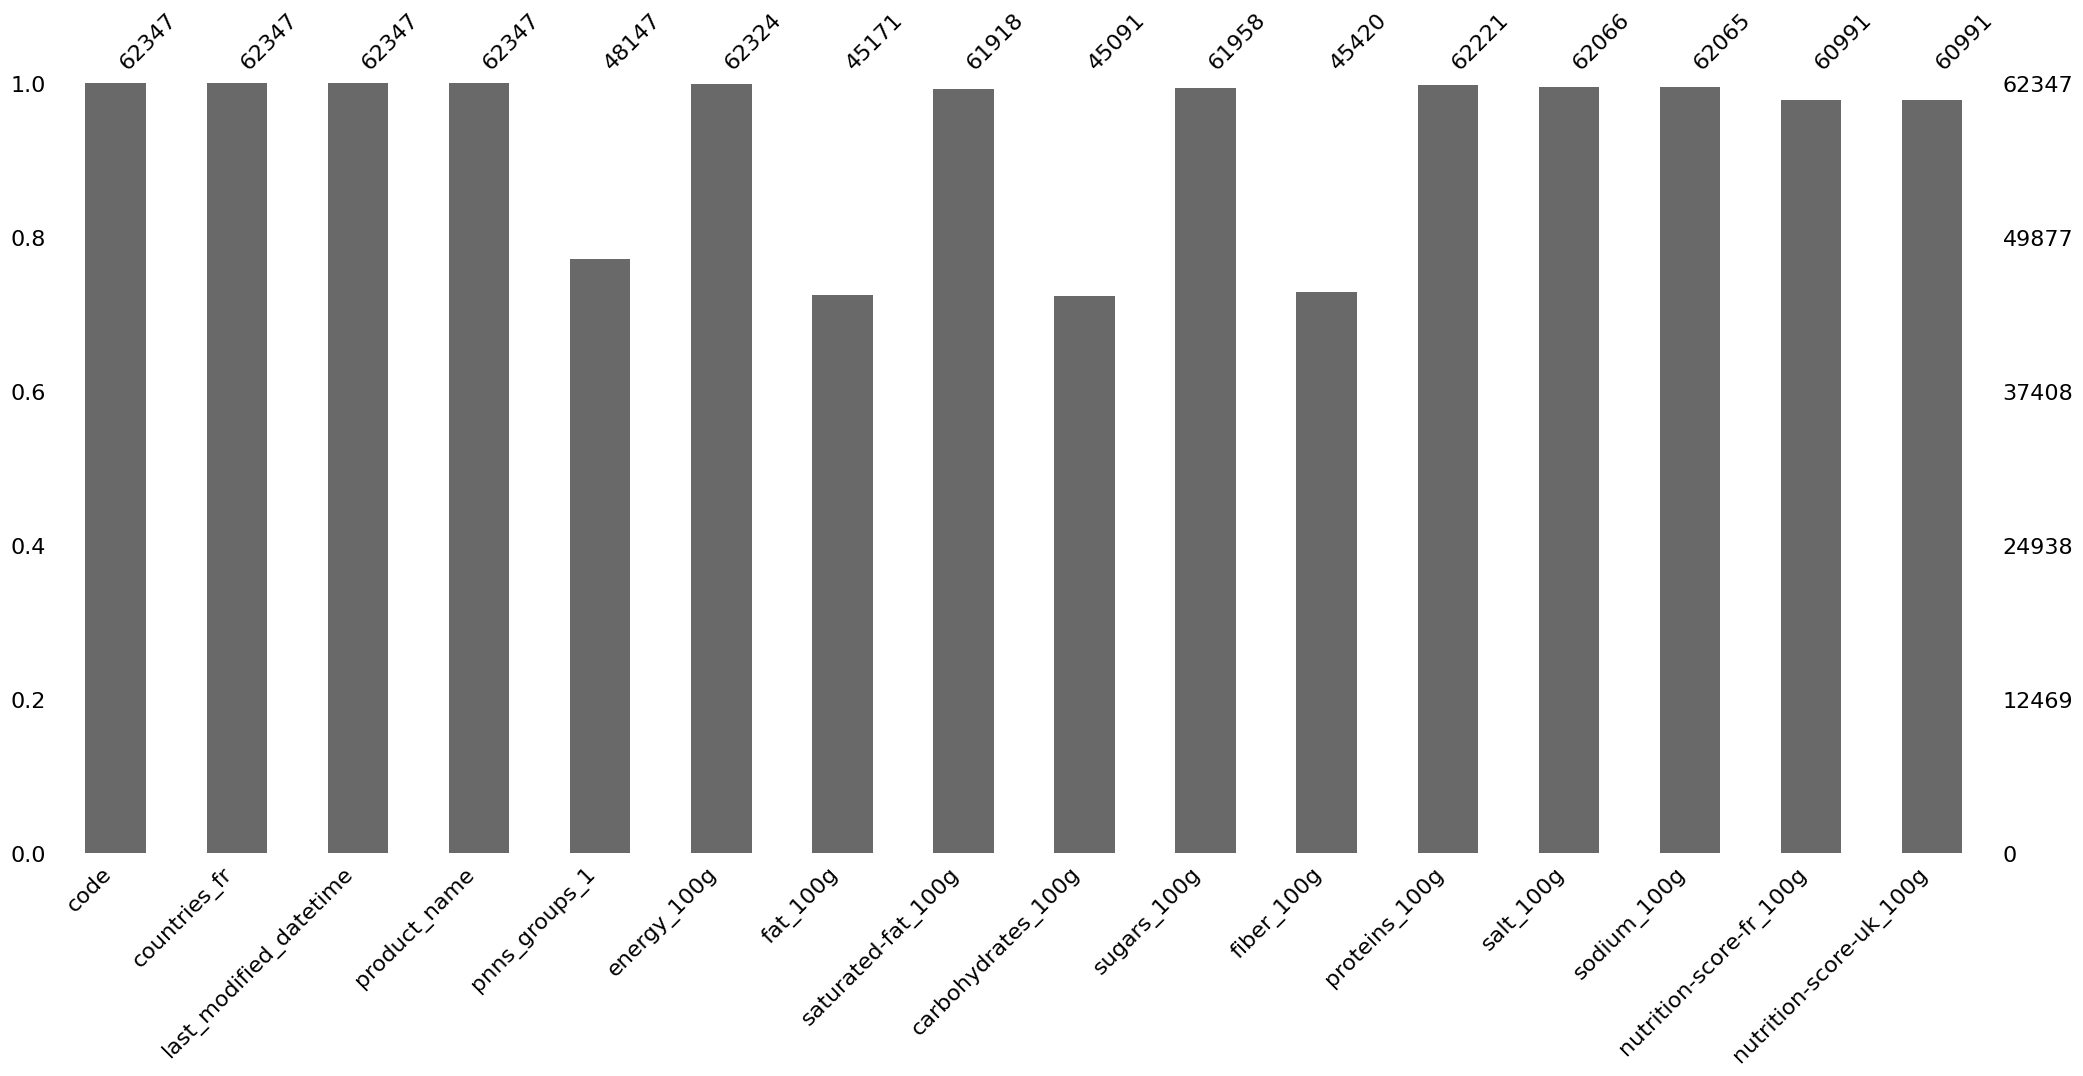

Verification des dépassements des limites de concentration pour 100g
Calories : Valeurs hors limites :  90  lignes supprimées


,code,countries_fr,last_modified_datetime,product_name,pnns_groups_1,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
56561,43647390011,France,2017-03-10T20:31:25Z,Tawny' Orange,NaN,5054.0,NaN,0.00,NaN,65.0,0.0,0.0,0.00,0.000000,20.0,20.0
161426,853807005163,France,2017-03-02T13:39:19Z,Huile d'avocat,NaN,3883.0,NaN,15.00,NaN,0.0,0.0,0.0,0.00,0.000000,20.0,20.0
178567,20193447,France,2017-04-08T18:48:53Z,Confiserie Firenze Apfel Streuselkuchen Tiefge...,NaN,4197.0,NaN,3.90,NaN,18.5,0.0,2.9,0.11,0.043307,17.0,17.0
178787,20233679,France,2017-04-20T07:42:28Z,Halva with Almonds,Sugary snacks,9983.0,36.8,7.80,44.2,32.0,NaN,12.9,0.00,0.000000,24.0,24.0
179179,2030502431284,France,2017-02-19T13:55:36Z,Lot De 4 Baguettes,NaN,4184.0,NaN,0.00,NaN,0.0,0.0,0.0,0.00,0.000000,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304297,8016857024016,France,2017-02-23T11:28:53Z,Gnocchi E Pasta Fresca,NaN,4828.0,NaN,3.52,NaN,1.9,2.3,9.8,1.12,0.440945,14.0,14.0
305223,8034063244592,France,2017-02-25T14:49:11Z,Miel D'eucalyptus,NaN,5749.0,NaN,0.00,NaN,80.0,0.0,0.4,0.01,0.003937,20.0,20.0
313852,8711200595631,France,2017-04-20T17:51:02Z,Cornetto Mini X8 Fruit,NaN,5644.0,NaN,13.00,NaN,24.0,0.0,3.7,0.12,0.047244,25.0,25.0
319695,9310804500189,France,2017-03-15T10:39:08Z,Miel,NaN,5925.0,NaN,0.00,NaN,82.0,0.0,0.0,0.00,0.000000,20.0,20.0


fat_100g : Valeurs hors limites :  1  lignes supprimées


,code,countries_fr,last_modified_datetime,product_name,pnns_groups_1,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
305054,8032942610032,France,2017-03-17T14:09:22Z,Graine de couscous moyen,Cereals and potatoes,1482.0,105.0,0.3,70.0,2.5,NaN,12.0,0.01,0.003937,-1.0,-1.0


carbohydrates_100g : Valeurs hors limites :  4  lignes supprimées


,code,countries_fr,last_modified_datetime,product_name,pnns_groups_1,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
155609,838619000254,France,2017-02-14T14:27:14Z,Beurre d'érable,unknown,1390.0,0.0,0.0,164.0,72.7,NaN,0.0,NaN,NaN,NaN,NaN
202571,3229820787909,France,2015-04-07T17:17:55Z,Sirop d'Agave brun bio,unknown,1760.0,0.0,0.0,104.0,104.0,0.0,0.0,0.14,0.05510,15.0,15.0
260599,4016249015732,France,2016-11-26T09:38:10Z,Sirop d agave pur,unknown,1760.0,1.0,0.1,103.5,103.5,NaN,1.0,0.10,0.03937,15.0,15.0
317635,8935000901649,France,2017-03-08T21:19:58Z,Banane sèche,Fruits and vegetables,1259.0,0.0,0.0,139.0,41.5,0.0,5.0,0.00,0.00000,4.0,4.0


sugars_100g : Valeurs hors limites :  1  lignes supprimées


,code,countries_fr,last_modified_datetime,product_name,pnns_groups_1,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
195761,3161712000928,France,2016-06-11T15:40:10Z,Caprice des dieux,Milk and dairy products,1379.0,30.0,21.0,0.8,-0.1,NaN,15.3,1.4,0.551181,15.0,20.0


fiber_100g : Valeurs hors limites :  1  lignes supprimées


,code,countries_fr,last_modified_datetime,product_name,pnns_groups_1,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
298897,7622210988768,France,2017-04-16T19:38:10Z,Milka Schmunzelhase Alpenmilch 175G,unknown,2218.0,29.0,18.0,59.0,58.0,178.0,6.3,0.37,0.145669,22.0,22.0


salt_100g : Valeurs hors limites :  2  lignes supprimées


,code,countries_fr,last_modified_datetime,product_name,pnns_groups_1,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
232239,3423720002432,France,2017-02-01T21:21:33Z,Keeny Bio,Sugary snacks,1720.0,23.0,3.33,47.8,26.7,0.741,6.3,211.0,83.000000,22.0,22.0
233372,3445850070259,France,2017-03-03T14:08:14Z,Sel de Guérande Label Rouge,unknown,0.0,0.0,0.00,0.0,0.0,0.000,0.0,125.0,49.212598,10.0,10.0


Correction des unités de sodium et suppression des lignes en anomalie
Nombre de lignes initial= 62248
Nombre de lignes final= 58151
Suppression des anomalies en sucre
Nombre de lignes initial= 58151
Nombre de lignes final= 58111
Suppression des anomalies en gras
Nombre de lignes initial= 58111
Nombre de lignes final= 58094
Correction des labels pour pnns_groups_1 :
Labels initiaux : ['unknown' nan 'Beverages' 'Sugary snacks' 'Composite foods'
 'Fruits and vegetables' 'Milk and dairy products' 'Salty snacks'
 'Cereals and potatoes' 'Fat and sauces' 'Fish Meat Eggs'
 'fruits-and-vegetables' 'sugary-snacks' 'cereals-and-potatoes']
Labels corrigés : ['unknown' nan 'Beverages' 'Sugary snacks' 'Composite foods'
 'Fruits and vegetables' 'Milk and dairy products' 'Salty snacks'
 'Cereals and potatoes' 'Fat and sauces' 'Fish Meat Eggs']
Imputation des données manquantes :


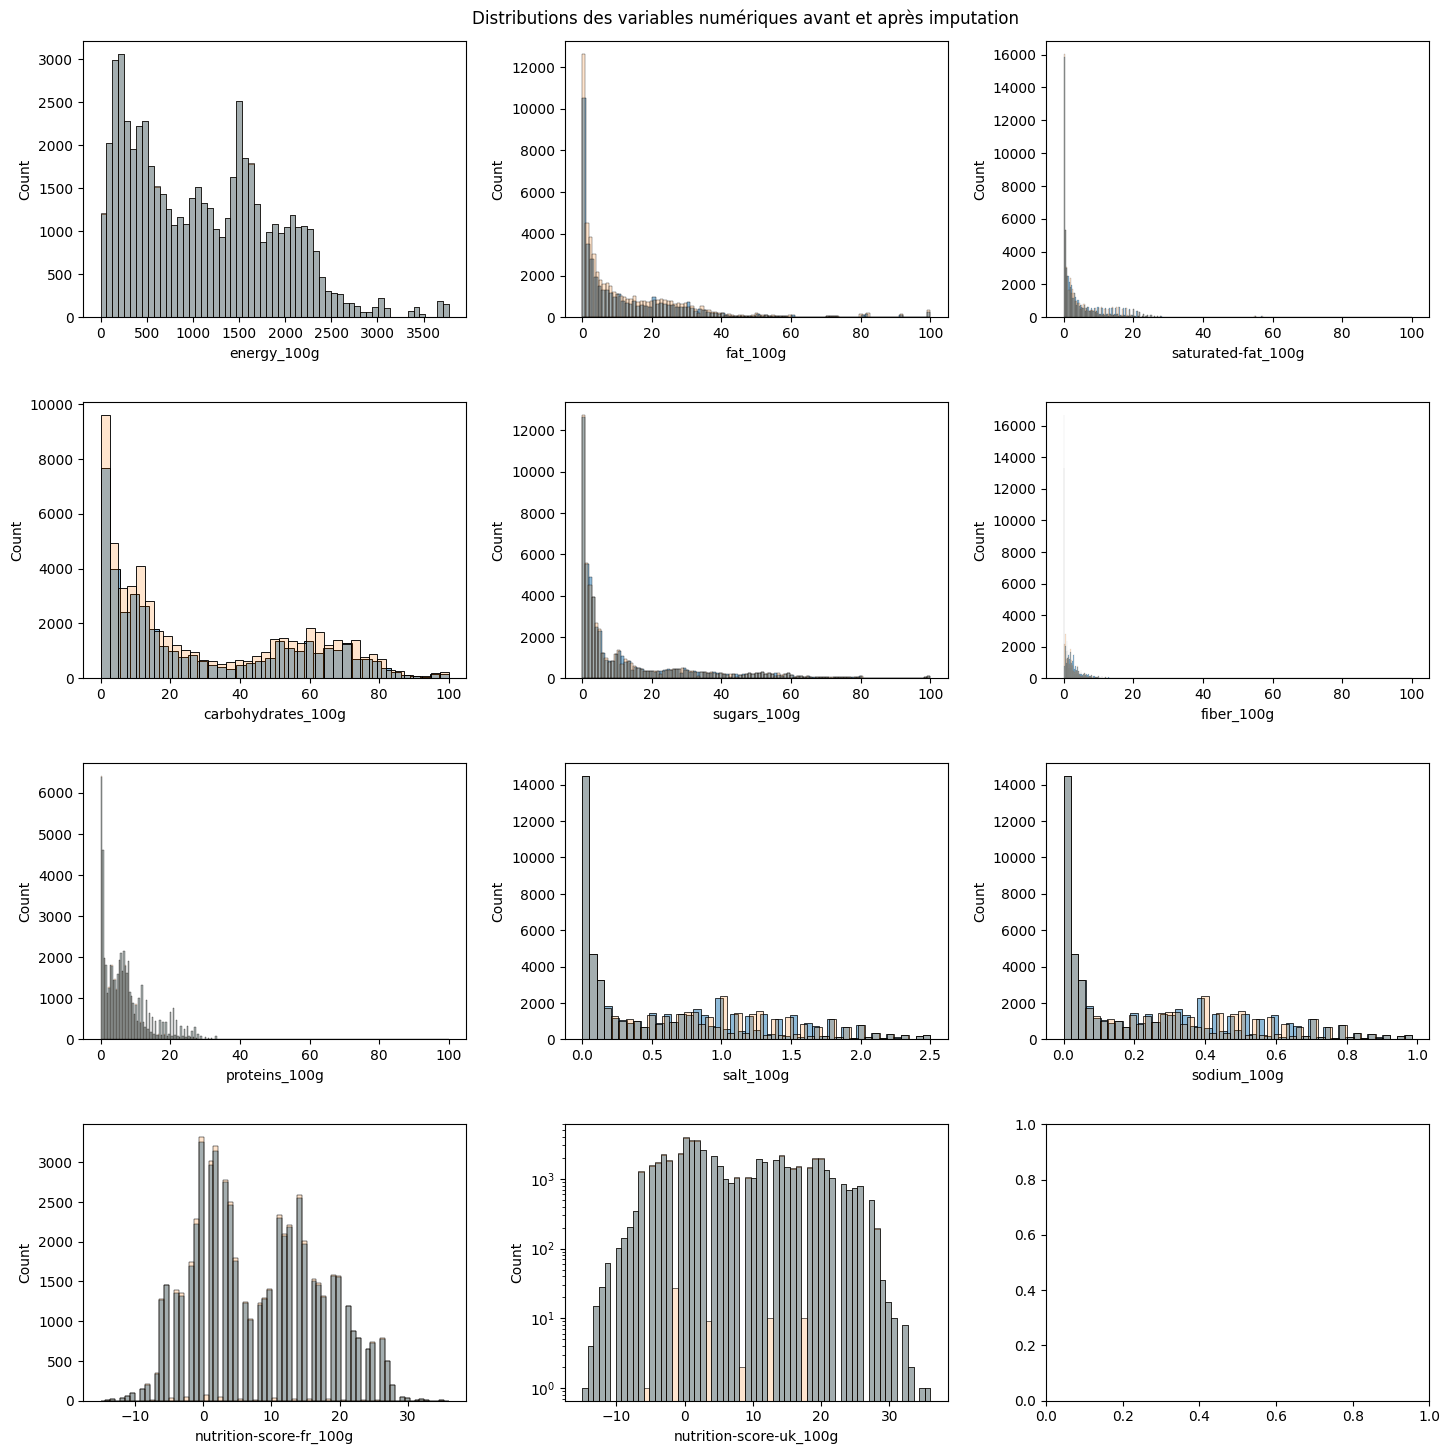

In [24]:
processed_data=pipeline.transform(data)

In [25]:
processed_data.to_csv('./data/processed_data.csv')